# My implementation of DQN in cartpole environment

DQN has 3 keys:

1. replay buffer

2. policy net & target net

3. epsilon greedy search algorithm

Then we should train the network and update the parameters

## gym information

In this notebook I will use the env "CartPole"

%pip install "gymnasium[atari]"
%pip install "gymnasium[accept-rom-license]"

In [48]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
env = gym.make('CartPole-v1',render_mode = 'rgb')

/Users/gaohaitao/opt/anaconda3/envs/robotics/lib/python3.10/site-packages/gymnasium/envs/registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


In [50]:
print(f'obvervation space: {env.observation_space}')
print(f'action space: {env.action_space}')

obvervation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


In [51]:
state, info = env.reset()
action = env.action_space.sample()
print(f'state: {state.shape}')
print(f'action: {action}')

state: (4,)
action: 1


## Build the Replay Buffer

In [52]:
import numpy as np
import random # epsilon greedy search
from collections import namedtuple,deque # Replay Buffer
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F

In [53]:
Transition = namedtuple('Transition',('state','action','next_state','reward','done'))
class Replay_Buffer(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

In [54]:
# test the function of Replay Buffer
state, info = env.reset()
terminated = False
truncated = False
done = terminated or truncated
buffer = Replay_Buffer(10)
batch_size = 3
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    buffer.push(state,action,next_state,reward,done)
    
    if done:
        break
    
    state = next_state
    
print(f'buffer len: {buffer.__len__()}')
transition = buffer.sample(batch_size)
batch = Transition(*zip(*transition))
batch_state = torch.tensor(batch.state).view(batch_size,-1)
batch_state.shape

buffer len: 10


torch.Size([3, 4])

## build an agent to play the game

agent pipeline

1. init: initialize the basic parameters

2. act: the strategy to choose an action given a state

3. step: take the action and obtain the observation and rewards

4. update: use the next observation and reward to update the network

5. train: to train the model

6. evaluate: to estimate the performance of agent

7. record the video

In [55]:
class QNetwork(nn.Module):
    def __init__(self,
                 state_space,
                 action_space,
                 lr,
                 fc1_unit = 1024,
                 fc2_unit = 512):
        super(QNetwork,self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.fc1_unit = fc1_unit
        self.fc2_unit = fc2_unit
        
        self.fc1 = nn.Linear(state_space,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_space)
        
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self,x):
        # x: `Batch_size,state_space`
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [56]:
# Hyperparameters
BUFFER_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 0.0001
UPDATE_EVERY = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
class agent():
    """the agent to play the game"""
    def __init__(self,
                 env,
                 state_space,
                 action_space,
                 buffer_size,
                 batch_size,
                 gamma,
                 update_every,
                 tau,
                 n_training_episode,
                 n_eval_episode,
                 min_epsilon,
                 max_epsilon,
                 decay_rate,
                 max_step,
                 lr,
                 device):
        
        self.env = env
        self.state_space = state_space
        self.action_spcae = action_space
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.n_training_episode = n_training_episode
        self.n_eval_episode = n_eval_episode
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.decay_rate = decay_rate
        self.max_step  =max_step
        self.update_every = update_every
        self.tau = tau
        self.batch_size = batch_size
        
        self.policy_net = QNetwork(state_space,
                                   action_space,
                                   lr).to(device)
        # self.target_net = QNetwork(state_space,
        #                            action_space,
        #                            lr).to(device)
        # self.loss = nn.MSELoss()
        # self.optim = optim.Adam(self.policy_net.parameters(),lr = lr)
        
        self.memory = Replay_Buffer(buffer_size)
        
        # self.t_step = 0 # cummulate and reset when the value = UPDATE_EVERY
        
    def act(self,state,ep = 0):
        # choose an action given a state
        # ep: epsilon greedy search
        
        p = random.random()
        
        # data type is different from Q-learning since we need convert it to tensor that can be put in GPU
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        # we use the policy network to choose the action
        # self.policy_net.eval()
        # with torch.no_grad():
        #     action_values = self.policy_net(state)
        # self.policy_net.train()
        
        if p > ep:
            action_values = self.policy_net(state)
            action = torch.argmax(action_values).item()
            return action
        else:
            return self.env.action_space.sample()
        
    def step(self,state,ep = 0):
        # the agent takes the action and obtain the next_state and reward
        action = self.act(state,ep)
        next_state,reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.memory.push(state,action,next_state,reward,done)
        return next_state,reward,terminated,truncated
        
        
    def update(self):
        # the agent use the a batch experiences to update the parameters
        if self.memory.__len__() >= self.batch_size:
            
            self.policy_net.optimizer.zero_grad()
            
            # print("extract batch and train...")
            transition = self.memory.sample(self.batch_size)
            
            batch = Transition(*zip(*transition))
            # print(batch.state)
            # put them into the GPU except actions
            b_states = torch.tensor(batch.state).view(self.batch_size,-1).to(self.device)
            # print(b_states.shape)
            b_actions = np.array(batch.action)
            # print(b_actions.shape)
            b_rewards = torch.tensor(batch.reward).view(self.batch_size,-1).to(self.device)
            # print(b_rewards.shape)
            b_next_states = torch.tensor(batch.next_state).view(self.batch_size,-1).to(self.device)
            # print(batch.next_state)
            # print(b_next_states.shape)
            b_dones = torch.tensor(batch.done).to(self.device)
            # print(b_dones.shape)
            # print(f'action: {action}')
            # print(f'state: {b_states.shape}')
            # print(f'next state: {b_next_states.shape}')
            
            # self.policy_net.train()
            # self.target_net.eval()
            
            batch_idx = np.arange(self.batch_size,dtype=np.int32)
            # pred_q_value = self.policy_net(b_states).gather(1,b_actions)
            pred_q_value = self.policy_net(b_states)[batch_idx,b_actions]
            
            # with torch.no_grad():
                # next_max_q_value = self.target_net(b_next_states).detach().max(1)[0].unsqueeze(1)
            next_max_q_value = self.policy_net(b_next_states)
            next_max_q_value[b_dones] = 0.0
                # next max Q value: `Batch 1`
                
            target_q_value = b_rewards + self.gamma * torch.max(next_max_q_value,dim = 1)[0]
            loss = self.policy_net.loss(pred_q_value,target_q_value).to(self.device)
          
            loss.backward()
            self.policy_net.optimizer.step()
            
            # self.t_step += 1
            
            # if self.t_step % self.update_every == 0:
            #     # copy the policy network's paramaters to target network
            #     # Q_target = tau * Q_policy + (1 - tau) * Q_target
            #     for target_param, policy_param in zip(self.target_net.parameters(),self.policy_net.parameters()):
            #       target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)
        
        else:
            return 
        #     print("add to the buffer...")
                        
    def train(self):
        scores,avg_scores = [],[]
        
        for episode in range(self.n_training_episode):
            # we should update the epsilon at very episode firstly
            ep = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
            print(f'episode: {episode} | epsilon: {ep}')
            
            state,info = self.env.reset()
            step = 0
            score = 0
            terminated = False
            truncated = False
            
            # iter every step in each episode
            # TODO debug this loop
            for step in range(self.max_step):
                next_state,reward,terminated,truncated = self.step(state,ep = ep)
                self.update()
                score += reward
                state = next_state
                # scores.append(score)
                # scores_window.append(score)
                
                if terminated or truncated:
                    break
                
                # state = next_state
            
            scores.append(score)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            
            if episode % 1 == 0:
                # print(f'episode: {episode} | average score: {np.mean(scores_window)}')
                print(f'episode: {episode} | score: {score} | avg score: {avg_score}')
            
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.suptitle('Training Progress')

        ax1.plot(scores, label='Episode Scores', color='b')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('scores', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2.plot(avg_scores, label='Episode Average Score', color='r')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Score', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

        plt.show()
            
            # if np.mean(scores_window) >= 200.0:
            #     print(f'The agent play the game sucessfully at {episode}, the average score is: {np.mean(scores_window)}')
            #     break
                

In [58]:
state_space = env.observation_space.shape[0]
# print(state_space)
action_space = env.action_space.n
n_training_episodes = 300
n_eval_episodes = 100
lr = 0.001
max_step = 100000
gamma = 0.95
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.005

# Instance agent
CartPoleAgent = agent(env,
                      state_space,
                      action_space,
                      BUFFER_SIZE,
                      BATCH_SIZE,
                      gamma,
                      UPDATE_EVERY,
                      TAU,
                      n_training_episodes,
                      n_eval_episodes,
                      min_epsilon,
                      max_epsilon,
                      decay_rate,
                      max_step,
                      lr,
                      device = device)

/Users/gaohaitao/opt/anaconda3/envs/robotics/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


episode: 0 | epsilon: 1.0
episode: 0 | score: 23.0 | avg score: 23.0
episode: 1 | epsilon: 0.9952618552330482
episode: 1 | score: 20.0 | avg score: 21.5
episode: 2 | epsilon: 0.9905473420617097
episode: 2 | score: 10.0 | avg score: 17.666666666666668
episode: 3 | epsilon: 0.9858563426229096
episode: 3 | score: 16.0 | avg score: 17.25
episode: 4 | epsilon: 0.9811887396414175
episode: 4 | score: 21.0 | avg score: 18.0
episode: 5 | epsilon: 0.976544416426916
episode: 5 | score: 18.0 | avg score: 18.0
episode: 6 | epsilon: 0.9719232568710827
episode: 6 | score: 11.0 | avg score: 17.0
episode: 7 | epsilon: 0.9673251454446882
episode: 7 | score: 27.0 | avg score: 18.25
episode: 8 | epsilon: 0.9627499671947071
episode: 8 | score: 20.0 | avg score: 18.444444444444443
episode: 9 | epsilon: 0.9581976077414449
episode: 9 | score: 17.0 | avg score: 18.3
episode: 10 | epsilon: 0.9536679532756783
episode: 10 | score: 61.0 | avg score: 22.181818181818183
episode: 11 | epsilon: 0.9491608905558097
epis

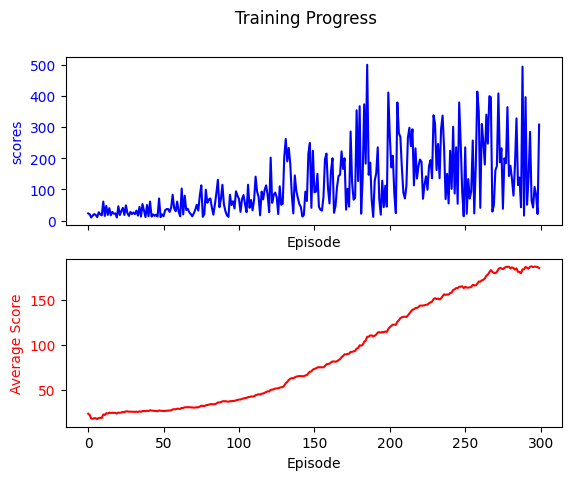

In [59]:
CartPoleAgent.train()

In [60]:
# TODO change one network to two networks